# Random walks $R_t$ factor with Student-t likelihood of daily cases with adjusted measurement for weekdays

In [1]:
from datetime import date
import locale
import calendar

import pandas as pd
import numpy as np
import pymc as pm
import pymc.sampling_jax
import arviz as az
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import aesara.tensor as tt

/usr/local/lib/python3.9/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/docs/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/usr/local/lib/python3.9/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
plt.figure()
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.figsize': [10, 5], 'figure.dpi': 95})

<Figure size 432x288 with 0 Axes>

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/treker-mk/data/master/csv/stats.csv')
data = data.assign(date = pd.to_datetime(data.date))
data = data[data.date.dt.date >= date(2020, 3, 20)]
data.tail(8)[['date', 'cases.confirmed']]

,date,cases.confirmed
881,2022-07-24,1261.0
882,2022-07-25,957.0
883,2022-07-26,897.0
884,2022-07-27,884.0
885,2022-07-28,855.0
886,2022-07-29,0.0
887,2022-07-30,0.0
888,2022-07-31,1171.0


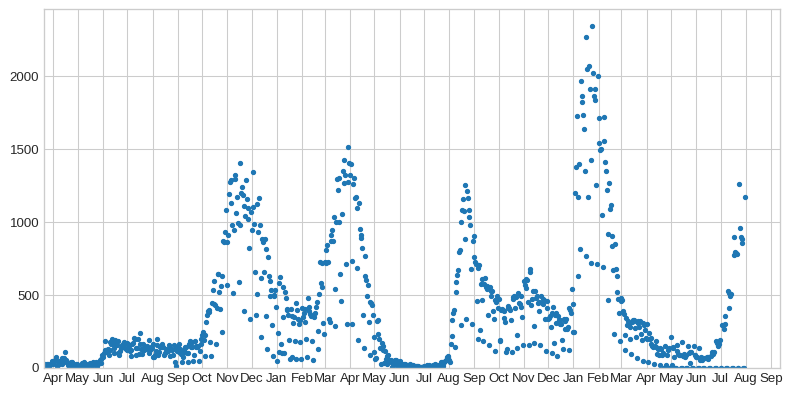

In [4]:
plt.scatter(data.date, data['cases.confirmed'], marker='.')
plt.gca().set(ylim=(-1, None), xlim=(data.date.min(), None))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

### Model

We model the new daily cases as simple reproduction with a Student's t likelihood:

$$ \text{observed}_t \sim t_\nu(\mu_t, \alpha) $$

The daily average is censored by a factor $ w_d $  depending on the day of week:

$$ \mu_t = w_{d_t} \overline \mu_t $$

where the true average is simply a multiple of the day before:

$$ \overline \mu_{t+1} = R_t  \overline \mu_t $$

which can be rewriten as:

$$ \log \overline \mu_{t+1} = \log \overline \mu_{t} + \log R_t $$

$$ \log \overline \mu_t = \log \overline  \mu_0 \sum_{\tau=1}^t \log R_{\tau} $$

We will model the $R_t$ as Gaussian random walk prior in the log scale (the factor is always positive):

$$ \log R_{t+1} \sim \mathcal{N}(\log R_t, \sigma^2) $$

and a regularizing hyperprior for $\sigma$:

$$ \sigma \sim \text{Half-Normal}(0.05^2) $$

The censoring should average out on a weekly level, i.e.:

$$ \sum_d w_d = 7 $$


therefore, we can use a Dirichlet prior:

$$ \frac{\mathbf w }{7} \sim \text{Dirichlet}(\mathbf 1) $$

Finally, for the scale parameter we will use log-normal prior, to avoid low values that might introduce an unidentifiability issues with respect to $\sigma$:

$$ \alpha \sim \text{Log-Normal}(\log 20, 1) $$

and for the degrees of freedom a standardized default prior:

$$ \nu \sim \text{Gamma}(2, 0.1) $$

In [8]:
mu0 = data['cases.confirmed'].values[0]
N = data.shape[0]
weekday_i = data.date.dt.weekday.values

with pm.Model() as model6:

    sigma = pm.HalfNormal('sigma', 0.01)
    logR = pm.GaussianRandomWalk(
        'logR',
        init_dist=pm.Normal.dist(0, 0.2),
        sigma=sigma,
        shape=N)

    R = pm.Deterministic('R', tt.exp(logR))
    mu_true = pm.Deterministic('mu_true', mu0 * tt.exp(tt.cumsum(logR)))

    # weekday censoring
    _w = pm.Dirichlet('_w', a=np.ones(7), shape=7, initval=np.ones(7)/7)
    w = pm.Deterministic('w', 7*_w)

    mu_observed = pm.Deterministic('mu_observed', mu_true * w[weekday_i])

    alpha = pm.Lognormal('alpha', np.log(20), 1)
    nu = pm.Gamma('nu', 2, 0.1)
    pm.StudentT(
        'obs', mu=mu_observed, sigma=alpha, nu=nu,
        observed=data['cases.confirmed'].values)

    trace6 = pm.sampling_jax.sample_numpyro_nuts(
        9000, tune=5000, chains=2, idata_kwargs=dict(log_likelihood=False)
    )

Compiling...
Compilation time =  0:00:09.075311
Sampling...


  0%|          | 0/14000 [00:00<?, ?it/s]

  0%|          | 0/14000 [00:00<?, ?it/s]

Sampling time =  0:16:13.386269
Transforming variables...
Transformation time =  0:00:02.063611


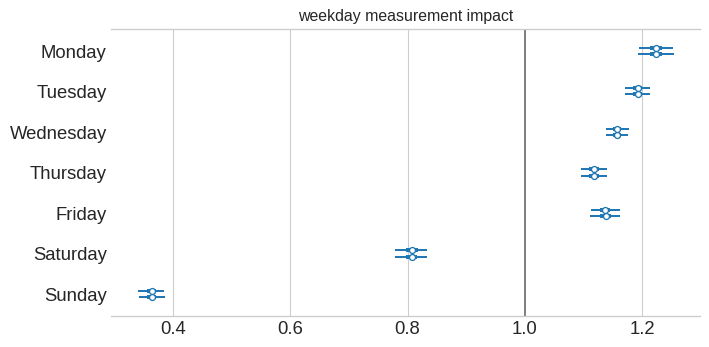

In [9]:
az.plot_forest(trace6, var_names=['w'], hdi_prob=0.95, figsize=(8, 4))
plt.gca().set(title='weekday measurement impact',
              yticklabels=(tuple(calendar.day_name)*2)[13:6:-1])
plt.axvline(1, color='gray')
None

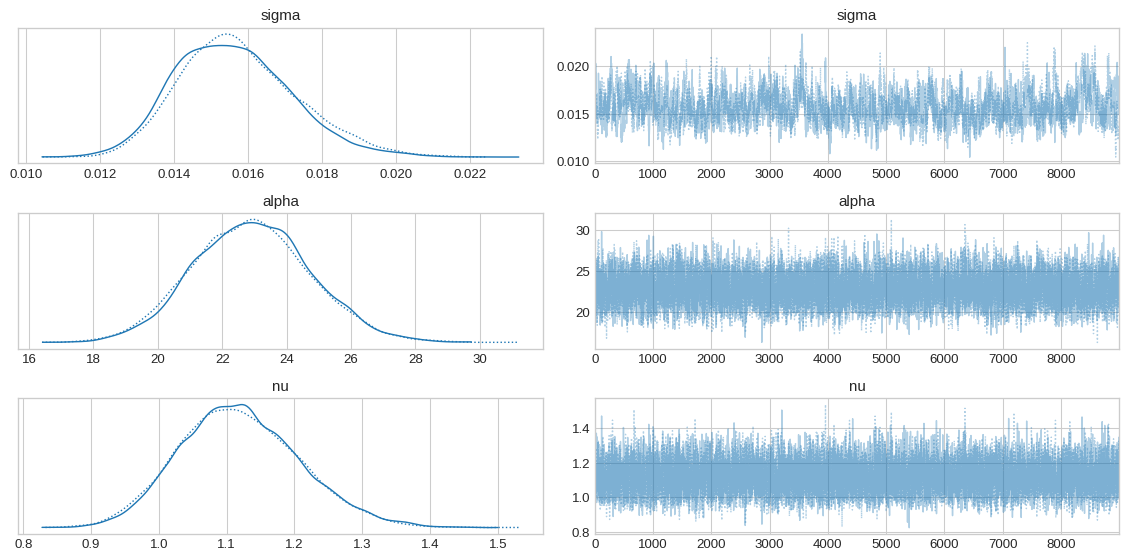

In [10]:
ax = az.plot_trace(trace6, var_names=['sigma', 'alpha', 'nu'])
ax[0, 0].get_figure().tight_layout()
None

In [11]:
trd = az.extract_dataset(trace6.posterior)

/tmp/ipykernel_1751/2798597265.py:4: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  tmp = az.hdi(trd.R.to_numpy().T, hdi_prob=0.95)
/tmp/ipykernel_1751/2798597265.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  tmp = az.hdi(trd.R.to_numpy().T, hdi_prob=0.5)
/tmp/ipykernel_1751/2798597265.py:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  tmp = az.hdi(trd.mu_true.to_numpy().T * trd.w.to_numpy()[:5].mean(axis=0).reshape(-1, 1),
/tmp/ipykernel_1751/2798597265.py:25: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  tmp = az.hdi(trd.mu_true

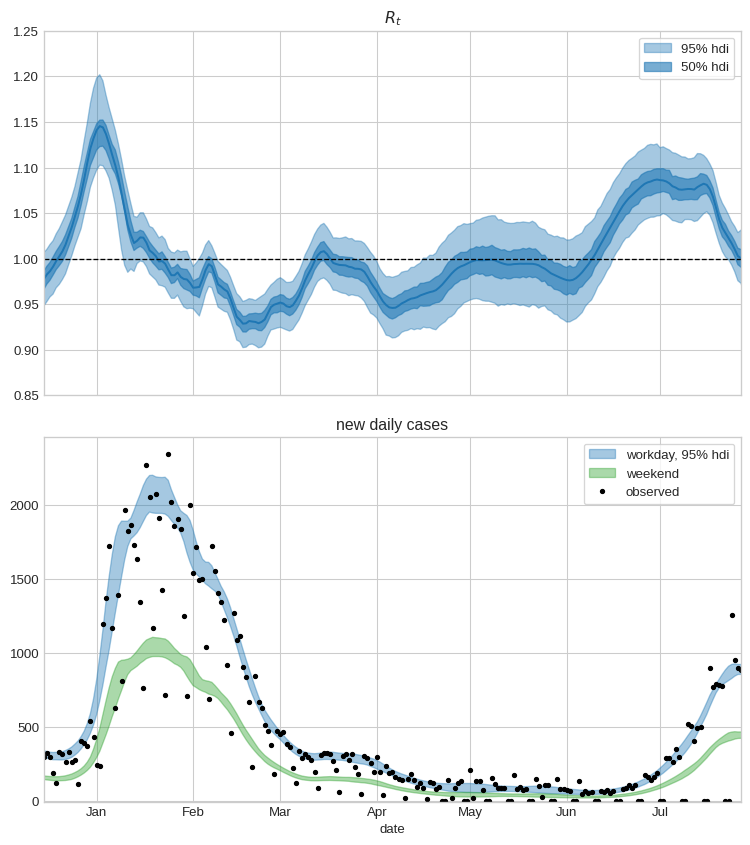

In [28]:
locale.setlocale(6, 'en_US.UTF-8')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 9), sharex=True)
tmp = az.hdi(trd.R.to_numpy().T, hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
tmp = tmp.assign(mean_ = trd.R.to_numpy().mean(axis=1))
tmp.mean_.plot(ax=ax1, label='')
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, color='C0', label='95% hdi')

tmp = az.hdi(trd.R.to_numpy().T, hdi_prob=0.5)
tmp = pd.DataFrame(tmp, index=data['date'])
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.6, color='C0', label='50% hdi')

ax1.axhline(1, linestyle='--', linewidth=1, color='k')
ax1.set(title='$R_t$', xlabel='date', ylim=(0.85, 1.25))
ax1.legend(frameon=True)

# # workday 6
tmp = az.hdi(trd.mu_true.to_numpy().T * trd.w.to_numpy()[:5].mean(axis=0).reshape(-1, 1),
             hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, label='workday, 95% hdi', color='C0')

# # weekend 6
tmp = az.hdi(trd.mu_true.to_numpy().T * trd.w.to_numpy()[5:].mean(axis=0).reshape(-1, 1),
             hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, label='weekend', color='C2')

ax2.plot(data['date'], data['cases.confirmed'],
         color='k', label='observed', marker='.', linewidth=0)
ax2.set(title='new daily cases', xlabel='date', ylim=(-1, None),
        xlim=(date(2021, 12, 15), data.iloc[-5].date))

ax2.legend(loc='upper right', frameon=True)
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

fig.tight_layout()
fig.savefig('mk_daily_R_en.png')
None

/tmp/ipykernel_1751/136485972.py:4: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  tmp = az.hdi(trd.R.to_numpy().T, hdi_prob=0.95)
/tmp/ipykernel_1751/136485972.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  tmp = az.hdi(trd.R.to_numpy().T, hdi_prob=0.5)
/tmp/ipykernel_1751/136485972.py:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  tmp = az.hdi(trd.mu_true.to_numpy().T * trd.w.to_numpy()[:5].mean(axis=0).reshape(-1, 1),
/tmp/ipykernel_1751/136485972.py:25: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  tmp = az.hdi(trd.mu_true.to_

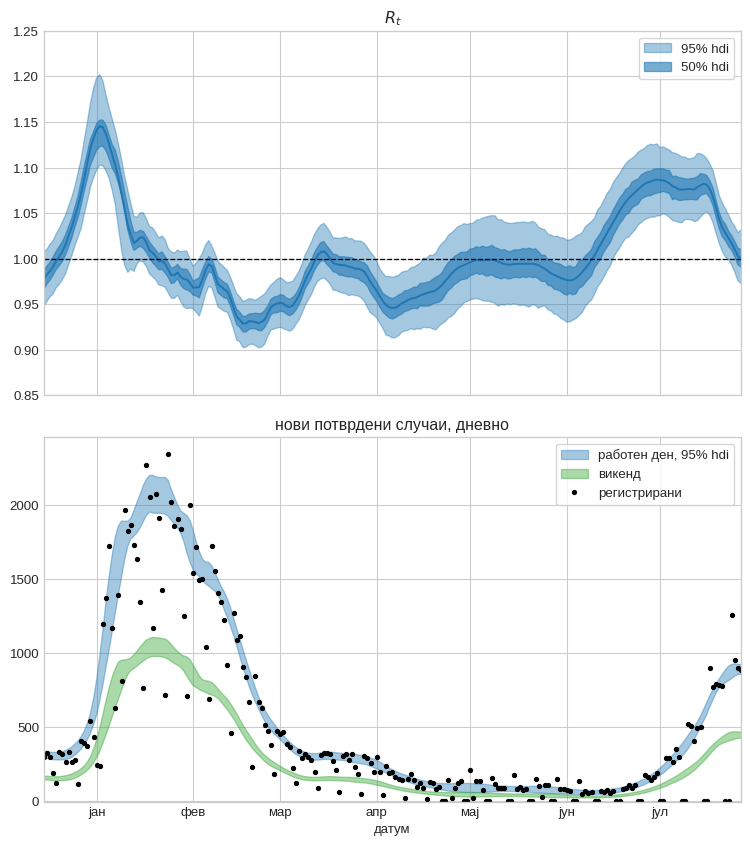

In [29]:
locale.setlocale(6, 'mk_MK.UTF-8')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 9), sharex=True)
tmp = az.hdi(trd.R.to_numpy().T, hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
tmp = tmp.assign(mean_ = trd.R.to_numpy().mean(axis=1))
tmp.mean_.plot(ax=ax1, label='')
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, color='C0', label='95% hdi')

tmp = az.hdi(trd.R.to_numpy().T, hdi_prob=0.5)
tmp = pd.DataFrame(tmp, index=data['date'])
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.6, color='C0', label='50% hdi')

ax1.axhline(1, linestyle='--', linewidth=1, color='k')
ax1.set(title='$R_t$', xlabel='датум', ylim=(0.85, 1.25))
ax1.legend(frameon=True)

# # workday 6
tmp = az.hdi(trd.mu_true.to_numpy().T * trd.w.to_numpy()[:5].mean(axis=0).reshape(-1, 1),
             hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, label='работен ден, 95% hdi', color='C0')

# # weekend 6
tmp = az.hdi(trd.mu_true.to_numpy().T * trd.w.to_numpy()[5:].mean(axis=0).reshape(-1, 1),
             hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, label='викенд', color='C2')

ax2.plot(data['date'], data['cases.confirmed'],
         color='k', label='регистрирани', marker='.', linewidth=0)
ax2.set(title='нови потврдени случаи, дневно', xlabel='датум', ylim=(-1, None),
        xlim=(date(2021, 12, 15), data.iloc[-5].date))

ax2.legend(loc='upper right', frameon=True)
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

fig.tight_layout()
fig.savefig('mk_daily_R.png')
None

---